## ASTR 598 - Homework 3 - Group 1

Dino Bektsevic, Meredith Durbin, Tyler Gordon, Joachim Moeyens, Brianna Thomas 

### Sections:
- [Create Data](#Create-Data)
- Problems
    - [1 and 2](#Problem-1-and-Problem-2)
    - [3](#Problem-3)
    - [4](#Problem-4)

Due on Thursday, February 15.

Last time we discussed fitting a burst + background model, with two types of burst profile: exponential decay and a gaussian profile. Let's now assume that we do not know which profile fits best and fit both profiles.

With Group 1 generating data using the exponential decay profile, and Group 2 using the gaussian profile (with the same parameters as in the lecture):

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from scipy.special import gamma
from scipy.stats import norm
from sklearn.neighbors import BallTree

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

% matplotlib inline

### Create Data

In [2]:
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y


def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

def get_logp(S, model):
    """compute log(p) given a pyMC model"""
    M = pymc.MAP(model)
    traces = np.array([S.trace(s)[:] for s in S.stochastics])
    logp = np.zeros(traces.shape[1])
    for i in range(len(logp)):
        logp[i] = -M.func(traces[:, i])
    return logp

def estimate_bayes_factor(traces, logp, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""
    D, N = traces.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces.T)
    count = bt.query_radius(traces.T, r=r, count_only=True)

    BF = logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)
    
# negative log likelihood computation
def neg_log_likelihood(model, data, err):
    return np.sum(0.5*((model-data)**2)/(err**2) + np.log((np.sqrt(2*np.pi)*err)))

In [3]:
def doEverythingAndBeLazy(truthModel="burst", N=100):
   
    t_fit = np.linspace(0, 100, 1000)

    if truthModel == "burst":
        np.random.seed(0)

        b0_true = 10
        A_true = 5
        alpha_true = 0.1
        T_true = 50
        sigma = 1.0

        t = 100 * np.random.random(N)
        t.sort()
        y_true = burst(t, b0_true, A_true, alpha_true, T_true)
        y_true_plot = burst(t_fit, b0_true, A_true, alpha_true, T_true)
        err_y = sigma
        y_obs = np.random.normal(y_true, sigma)

    elif truthModel == "gauss":
        np.random.seed(42)

        b0_true = 10
        A_true = 3
        sigma_true = 3.0
        T_true = 40
        err0_y = 0.5

        t = 100 * np.random.random(N)
        t.sort()
        y_true = GaussAndBkgd(t, b0_true, A_true, sigma_true, T_true)
        y_true_plot = GaussAndBkgd(t_fit, b0_true, A_true, sigma_true, T_true)
        err_y = np.random.uniform(0, 2*err0_y) + 0.5*np.sqrt(y_true/10) 
        y_obs = np.random.normal(y_true, err_y)
    
    
    ### Gaussian Model
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)
    labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']

    @pymc.deterministic
    def sigma(log_sigma=log_sigma):
        return np.exp(log_sigma)

    @pymc.deterministic
    def y_model_gauss(t=t, b0=b0, A=A, sigma=sigma, T=T):
        return GaussAndBkgd(t, b0, A, sigma, T)

    y_gauss = pymc.Normal('y', mu=y_model_gauss, tau=err_y ** -2, observed=True, value=y_obs)

    model_gauss = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model_gauss, y=y_gauss)

    @pickle_results('matchedfilt_gauss_truth{}_{}.pkl'.format(truthModel, N))
    def compute_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model_gauss)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]
        traces = np.array(traces)
        logp = get_logp(S, model_gauss)
        
        M = pymc.MAP(model_gauss)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)
           
        return traces, fit_vals, logp
    
    traces_gauss, fit_vals_gauss, logp_gauss = compute_MCMC_results()
    print("")
    
    ### Burst Model
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)
    labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']

    @pymc.deterministic
    def alpha(log_alpha=log_alpha):
        return np.exp(log_alpha)

    @pymc.deterministic
    def y_model_exp(t=t, b0=b0, A=A, alpha=alpha, T=T):
        return burst(t, b0, A, alpha, T)

    y_exp = pymc.Normal('y', mu=y_model_exp, tau=err_y ** -2, observed=True, value=y_obs)

    model_exp = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
                 alpha=alpha, y_model=y_model_exp, y=y_exp)

    @pickle_results('matchedfilt_burst_truth{}_{}.pkl'.format(truthModel, N))
    def compute_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model_exp)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]
        traces = np.array(traces)
        logp = get_logp(S, model_exp)
        
        M = pymc.MAP(model_exp)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

        return traces, fit_vals, logp
    
    
    traces_exp, fit_vals_exp, logp_exp = compute_MCMC_results()
    print("")
    
    ### Bayesian Factor Estimation as intelligent global likelihood
    BF_exp, dBF_exp = estimate_bayes_factor(traces_exp, logp_exp, r=0.02)
    BF_gauss, dBF_gauss = estimate_bayes_factor(traces_gauss, logp_gauss, r=0.02)
    
    print("Bayes Factor for Burst/Gauss: {}".format(BF_exp/BF_gauss))
    
    # Nice use of lambda functions by Tyler
    lnL_gauss = lambda params: neg_log_likelihood(GaussAndBkgd(t, *params), y_obs, err_y)
    lnL_exp = lambda params: neg_log_likelihood(burst(t, *params), y_obs, err_y)
    
    BIC_gauss = 2*lnL_gauss(fit_vals_gauss) - 2*np.log(len(y_obs))
    BIC_exp = 2*lnL_exp(fit_vals_exp) - 2*np.log(len(y_obs))
    print("BIC for Burst: {}".format(BIC_gauss))
    print("BIC for Gauss: {}".format(BIC_exp))
    
    ### Plot data and truth model
    fig, ax = plt.subplots(1, 1, dpi=150)
    ax.errorbar(t, y_obs, yerr=err_y, fmt="o", color="k", markersize=5, elinewidth=1, label="observed", alpha=0.6)
    ax.plot(t_fit, y_true_plot, label="truth", zorder=9)
    ax.set_xlabel(r"t");
    ax.set_ylabel(r"$y$");
    ax.legend(bbox_to_anchor=(1.01, 0.6));
    if truthModel == "burst":
        ax.set_title("Gaussian and Burst Fit for a Burst Model Truth")
    elif truthModel == "gauss":
        ax.set_title("Gaussian and Burst Fit for a Gaussian Model Truth")
    else:
        print("...")
        
    ### Plot data and MCMC results
    fig, ax = plt.subplots(1, 1, dpi=150)
    ax.errorbar(t, y_obs, yerr=err_y, fmt="o", color="k", markersize=5, elinewidth=1, label="observed", alpha=0.6)
    ax.plot(t_fit, y_true_plot, label="truth", lw=3, zorder=9)
    ax.set_xlabel(r"t");
    ax.set_ylabel(r"$y$");

    y_fit_gauss = GaussAndBkgd(t_fit, *fit_vals_gauss)
    y_fit_exp = burst(t_fit, *fit_vals_exp)

    ax.plot(t_fit, y_fit_gauss, label="gauss", lw=3, zorder=10)
    ax.plot(t_fit, y_fit_exp, label="burst", lw=3, zorder=10)
    ax.legend(bbox_to_anchor=(1.01, 0.6));
    if truthModel == "burst":
        ax.set_title("Gaussian and Burst Fit for a Burst Model Truth")
    elif truthModel == "gauss":
        ax.set_title("Gaussian and Burst Fit for a Gaussian Model Truth")
    else:
        print("...")

In [4]:
### DANGER ###
# ! rm *.pkl

### Problem 1 and Problem 2
Can you tell which model is correct using global likelihood computation?

Can you tell which model is correct using BIC?

@pickle_results: computing results and saving to 'matchedfilt_gauss_truthgauss_100.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.9 sec
@pickle_results: computing results and saving to 'matchedfilt_burst_truthgauss_100.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.7 sec
Bayes Factor for Burst/Gauss: 1.0861128793199135
BIC for Burst: 133.2707630757611
BIC for Gauss: 145.03565989393326


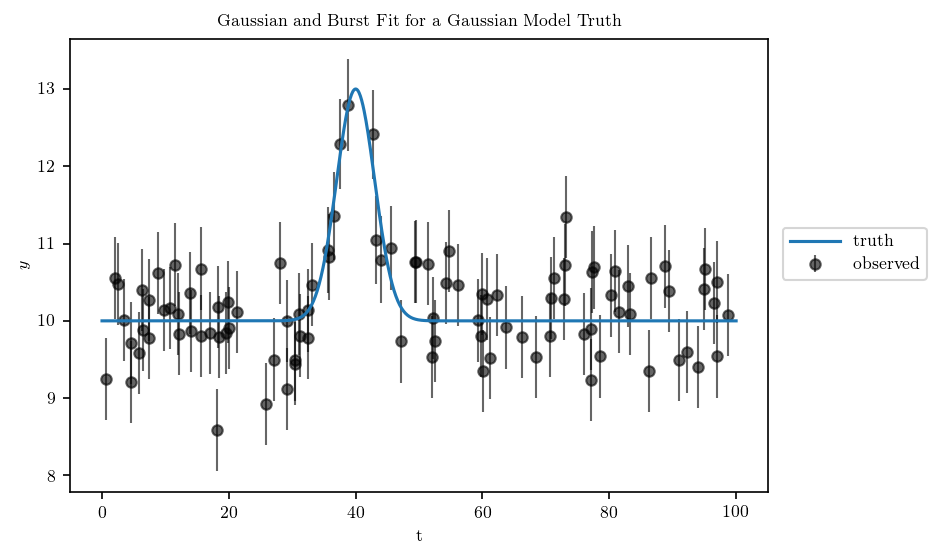

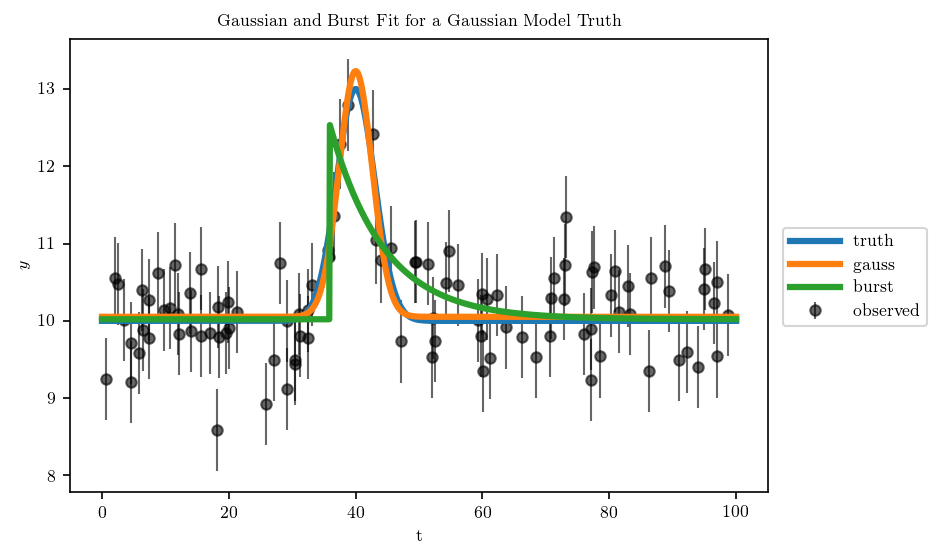

In [5]:
doEverythingAndBeLazy(truthModel="gauss")

@pickle_results: computing results and saving to 'matchedfilt_gauss_truthburst_100.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 5.1 sec
@pickle_results: computing results and saving to 'matchedfilt_burst_truthburst_100.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.8 sec
Bayes Factor for Burst/Gauss: 0.9884694273522076
BIC for Burst: 279.37923224003544
BIC for Gauss: 272.0841192563741


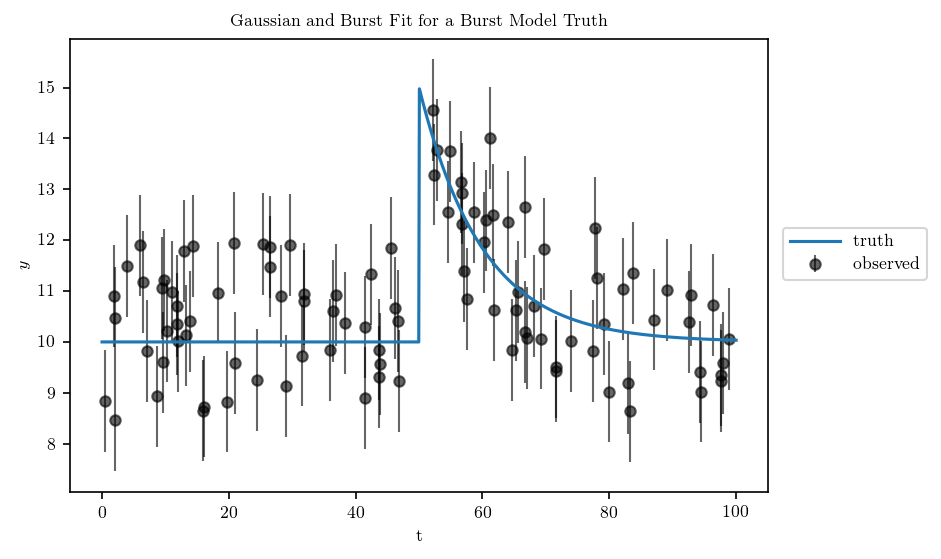

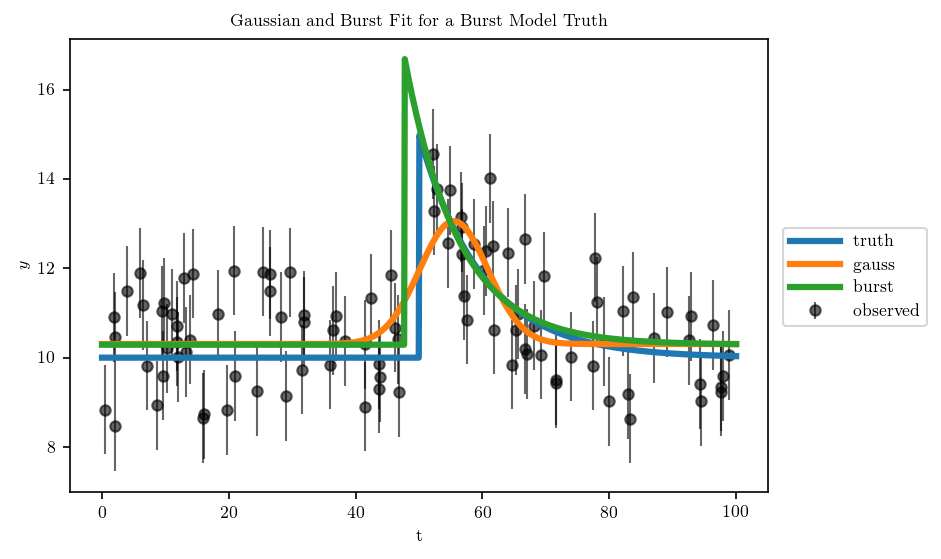

In [6]:
doEverythingAndBeLazy(truthModel="burst")

### Problem 3
What happens when you increase the number of data points by a factor of 2 (using BIC)?

@pickle_results: computing results and saving to 'matchedfilt_gauss_truthgauss_200.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 5.7 sec
@pickle_results: computing results and saving to 'matchedfilt_burst_truthgauss_200.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 5.2 sec
Bayes Factor for Burst/Gauss: 1.0081087888608262
BIC for Burst: 599.1463438973398
BIC for Gauss: 600.6706147139352


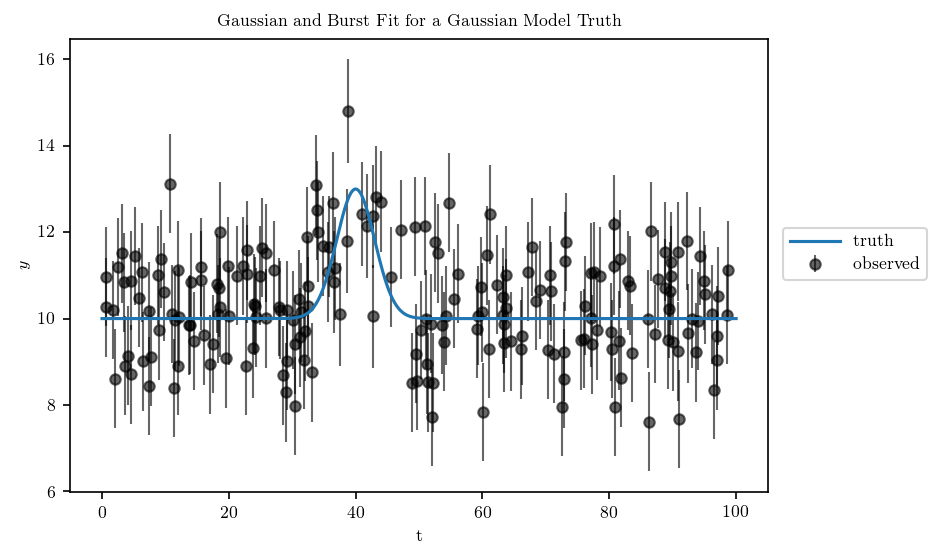

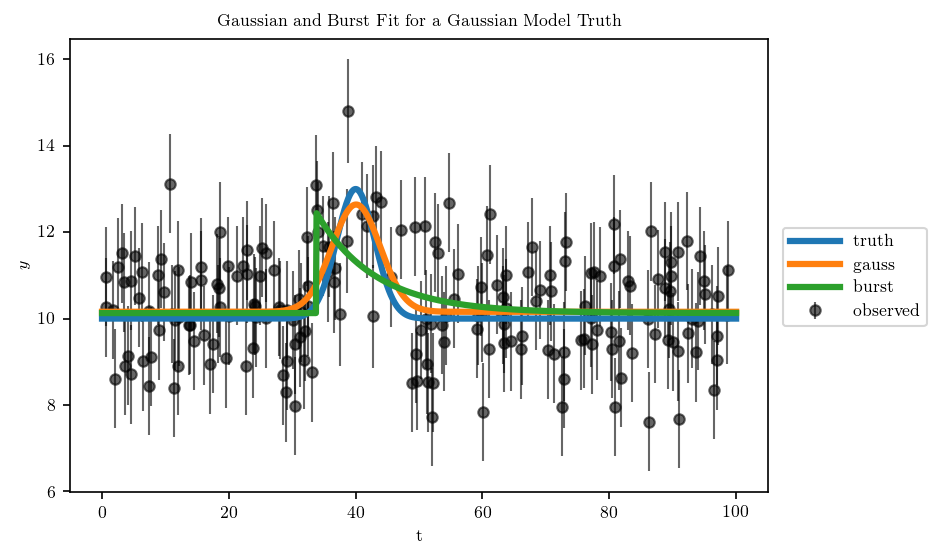

In [7]:
doEverythingAndBeLazy(truthModel="gauss", N=200)

@pickle_results: computing results and saving to 'matchedfilt_gauss_truthburst_200.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 5.3 sec
@pickle_results: computing results and saving to 'matchedfilt_burst_truthburst_200.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 5.3 sec
Bayes Factor for Burst/Gauss: 0.9372180807212378
BIC for Burst: 586.4410139666209
BIC for Gauss: 542.4601889202175


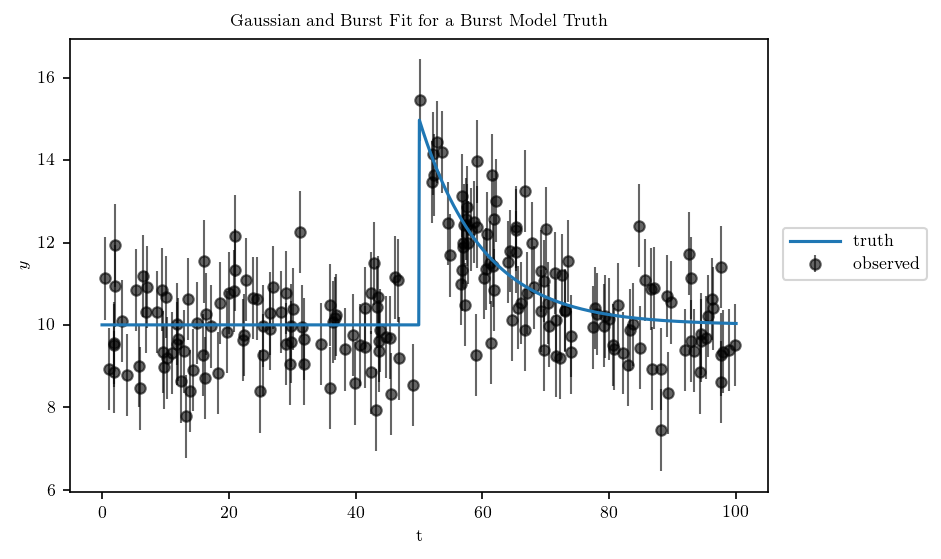

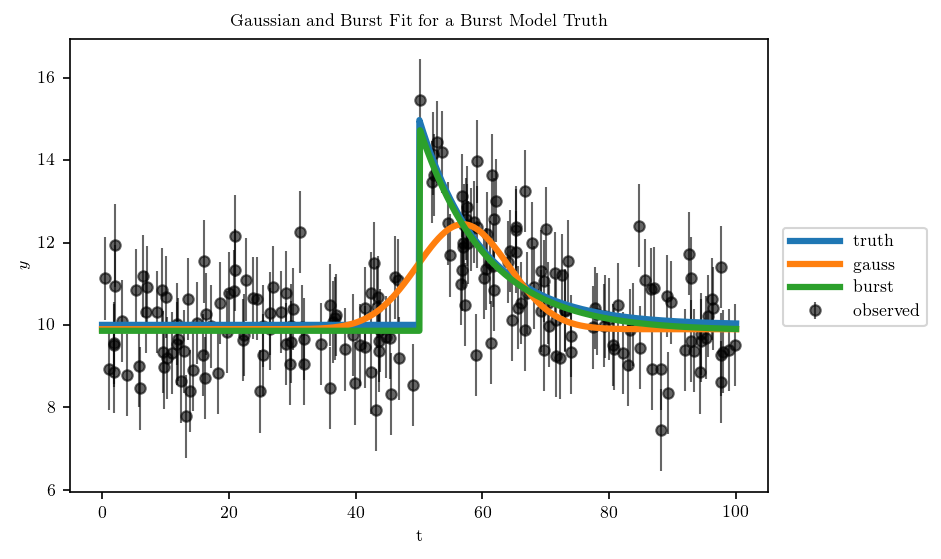

In [8]:
doEverythingAndBeLazy(truthModel="burst", N=200)

### Problem 4
What happens when you decrease the number of data points by a factor of 2 (using BIC)?

@pickle_results: computing results and saving to 'matchedfilt_gauss_truthgauss_50.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.5 sec
@pickle_results: computing results and saving to 'matchedfilt_burst_truthgauss_50.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.2 sec
Bayes Factor for Burst/Gauss: 1.0174495380178141
BIC for Burst: 172.40612039726415
BIC for Gauss: 164.3352962406833


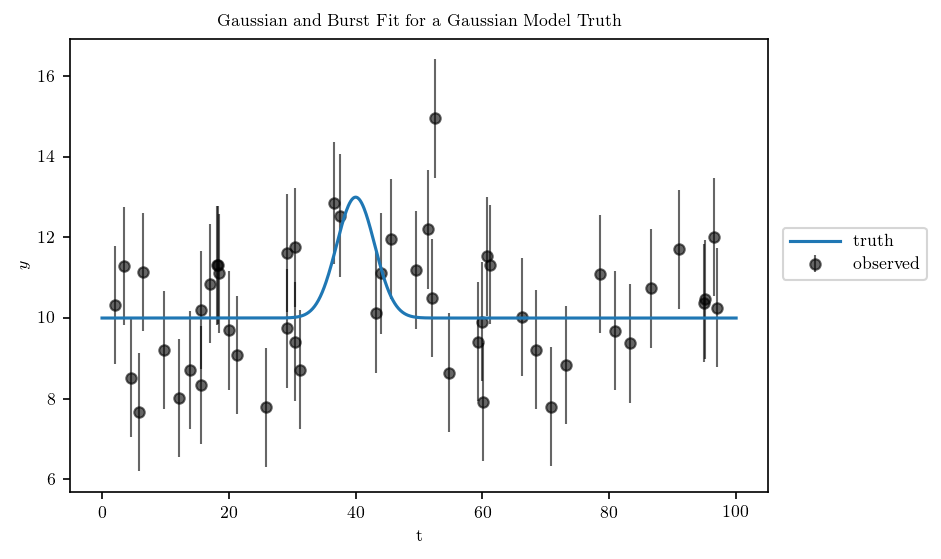

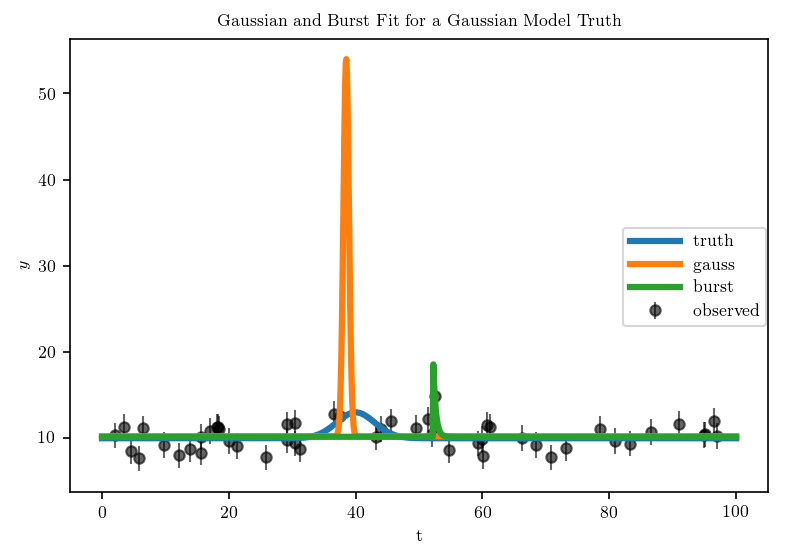

In [9]:
doEverythingAndBeLazy(truthModel="gauss", N=50)

@pickle_results: computing results and saving to 'matchedfilt_gauss_truthburst_50.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.8 sec
@pickle_results: computing results and saving to 'matchedfilt_burst_truthburst_50.pkl'
 [-----------------100%-----------------] 25000 of 25000 complete in 4.9 sec
Bayes Factor for Burst/Gauss: 0.990504843498019
BIC for Burst: 129.5700020278388
BIC for Gauss: 124.58318917026169


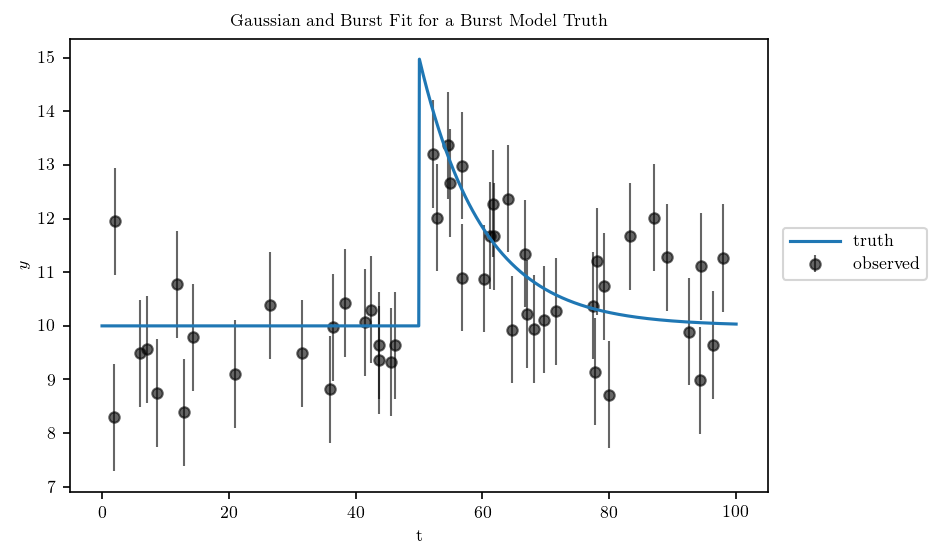

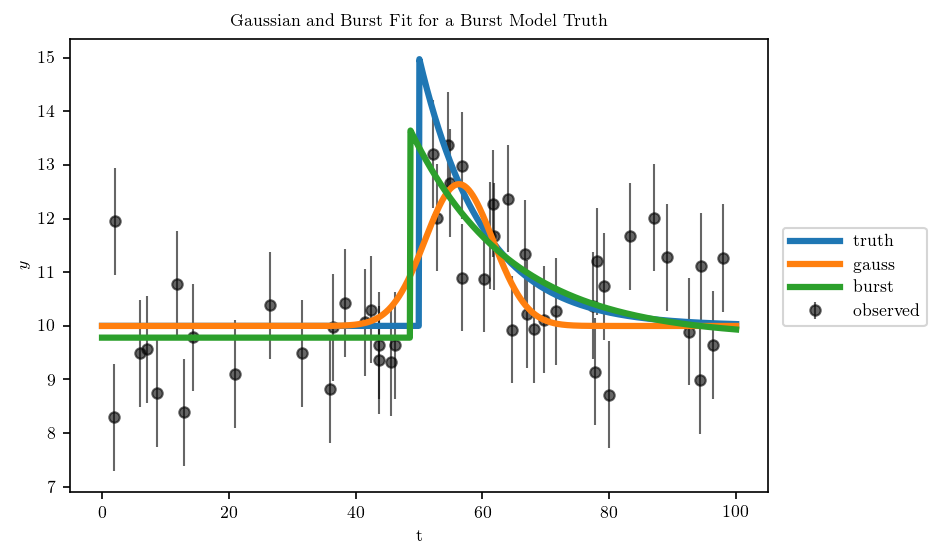

In [10]:
doEverythingAndBeLazy(truthModel="burst", N=50)